# Sugarcane Leaf Disease Classification

Setup

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


Load Data

In [8]:
data_dir = Path('./data')

if not data_dir.exists():
    print(f"ERROR: Data not found at {data_dir}")
else:
    classes = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
    print(f"Classes: {classes}")
    for class_name in classes:
        images = list((data_dir / class_name).glob('*.jpg')) + list((data_dir / class_name).glob('*.png'))
        print(f"  {class_name}: {len(images)} images")

Classes: ['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']
  Healthy: 0 images
  Mosaic: 0 images
  RedRot: 0 images
  Rust: 0 images
  Yellow: 0 images


Create DS Class

In [20]:
class SugarcaneDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.images = []
        self.labels = []
        
        self.classes = sorted([d.name for d in self.data_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        for class_name in self.classes:
            class_dir = self.data_dir / class_name
            for img_path in list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.jpeg')) + list(class_dir.glob('*.JPG')) + list(class_dir.glob('*.JPEG')):
                self.images.append(str(img_path))
                self.labels.append(self.class_to_idx[class_name])
        
        print(f"Found {len(self.images)} images total")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

Preprocessing + Transforms

In [21]:
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

In [22]:
full_dataset = SugarcaneDataset(data_dir, transform=train_transforms)
num_classes = len(full_dataset.classes)
class_names = full_dataset.classes

total_images = len(full_dataset)
print(f"Total images: {total_images}")
print(f"Classes: {class_names}")

if total_images == 0:
    print("ERROR: No images found! Check your data path.")
else:
    train_size = max(1, int(0.7 * total_images))
    val_size = max(1, int(0.15 * total_images))
    test_size = total_images - train_size - val_size
    
    print(f"Train: {train_size}, Val: {val_size}, Test: {test_size}")
    
    train_dataset = SugarcaneDataset(data_dir, transform=train_transforms)
    val_dataset = SugarcaneDataset(data_dir, transform=val_test_transforms)
    test_dataset = SugarcaneDataset(data_dir, transform=val_test_transforms)

Found 2521 images total
Total images: 2521
Classes: ['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']
Train: 1764, Val: 378, Test: 379
Found 2521 images total
Found 2521 images total
Found 2521 images total


DataLoaders

In [23]:
BATCH_SIZE = 16

try:
    train_loader = DataLoader(train_dataset, batch_size=min(BATCH_SIZE, len(train_dataset)), shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=min(BATCH_SIZE, len(val_dataset)), shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=min(BATCH_SIZE, len(test_dataset)), shuffle=False, num_workers=0)
    
    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")
    print("✓ DataLoaders created successfully!")
except Exception as e:
    print(f"Error creating DataLoaders: {e}")

Train batches: 158
Val batches: 158
Test batches: 158
✓ DataLoaders created successfully!


View Samples

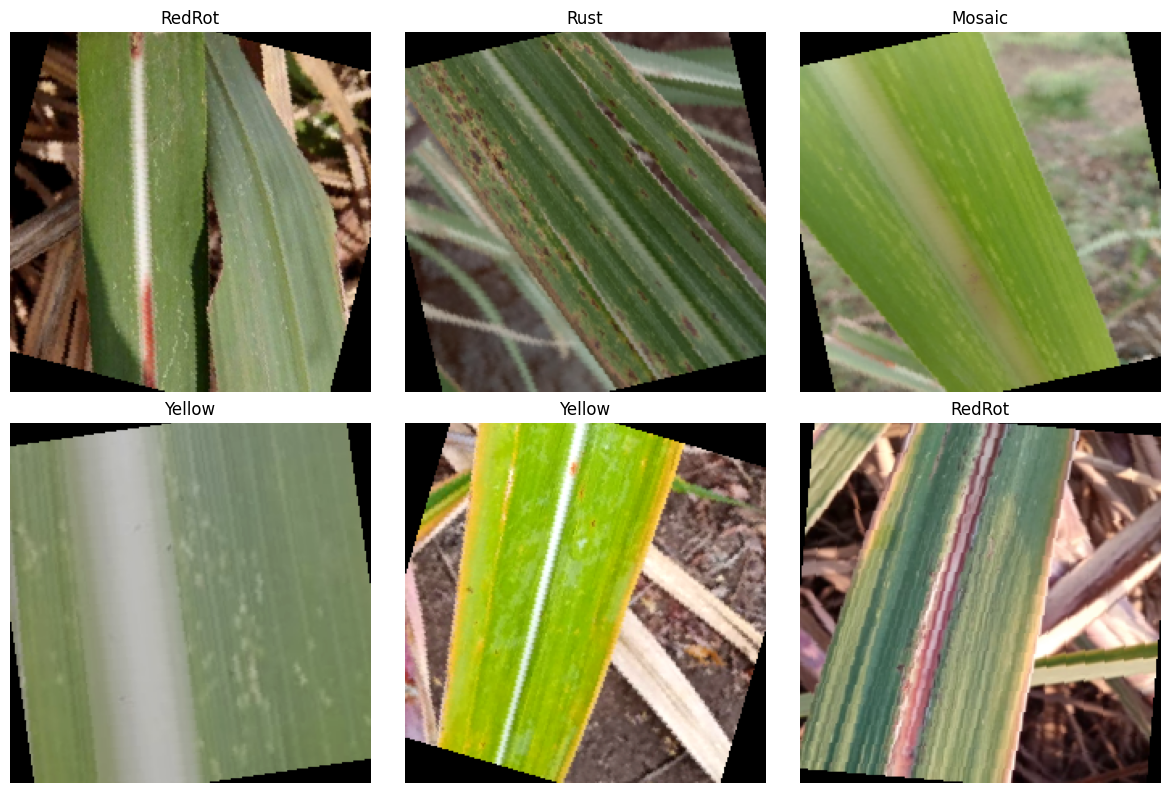

In [24]:
def denormalize(tensor):
    tensor = tensor.clone().detach()
    tensor = tensor.permute(1, 2, 0)
    for i in range(3):
        tensor[:,:,i] = tensor[:,:,i] * IMAGENET_STD[i] + IMAGENET_MEAN[i]
    return tensor.clamp(0, 1)

images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        img = denormalize(images[idx].cpu())
        ax.imshow(img)
        ax.set_title(f"{class_names[labels[idx].item()]}")
        ax.axis('off')
plt.tight_layout()
plt.show()

Model Buildin g

In [25]:
class Classifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(Classifier, self).__init__()
        self.backbone = models.resnet18(pretrained=pretrained)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

model = Classifier(num_classes=num_classes, pretrained=True)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/vishwakamalbabu/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:06<00:00, 7.24MB/s]


Total parameters: 11,441,733


Loss Control

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

print("✓ Loss function and optimizer initialized")

✓ Loss function and optimizer initialized


Training

In [28]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc='Training'):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validating'):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    return total_loss / len(val_loader), correct / total

In [29]:
NUM_EPOCHS = 20
PATIENCE = 5

history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
best_val_accuracy = 0
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
    
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    print(f"Training Loss: {train_loss:.4f}")
    
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    scheduler.step(val_loss)
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✓ Best model saved! (Accuracy: {val_accuracy:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\n⚠ Early stopping at epoch {epoch+1}")
            break

print(f"\nTraining complete! Best accuracy: {best_val_accuracy:.4f}")


Epoch [1/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [02:35<00:00,  1.01it/s]


Training Loss: 1.0619


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:16<00:00,  2.05it/s]


Validation Loss: 0.8281
Validation Accuracy: 0.6319
✓ Best model saved! (Accuracy: 0.6319)

Epoch [2/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [02:42<00:00,  1.03s/it]


Training Loss: 0.8543


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:17<00:00,  2.05it/s]


Validation Loss: 0.5486
Validation Accuracy: 0.7969
✓ Best model saved! (Accuracy: 0.7969)

Epoch [3/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [02:34<00:00,  1.02it/s]


Training Loss: 0.7305


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:17<00:00,  2.03it/s]


Validation Loss: 0.6169
Validation Accuracy: 0.8021
✓ Best model saved! (Accuracy: 0.8021)

Epoch [4/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [02:36<00:00,  1.01it/s]


Training Loss: 0.6608


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:17<00:00,  2.03it/s]


Validation Loss: 0.4471
Validation Accuracy: 0.8489
✓ Best model saved! (Accuracy: 0.8489)

Epoch [5/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [02:36<00:00,  1.01it/s]


Training Loss: 0.6232


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:17<00:00,  2.03it/s]


Validation Loss: 0.3802
Validation Accuracy: 0.8715
✓ Best model saved! (Accuracy: 0.8715)

Epoch [6/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [02:38<00:00,  1.00s/it]


Training Loss: 0.6117


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:19<00:00,  1.99it/s]


Validation Loss: 0.3296
Validation Accuracy: 0.8917
✓ Best model saved! (Accuracy: 0.8917)

Epoch [7/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [02:36<00:00,  1.01it/s]


Training Loss: 0.5444


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:17<00:00,  2.04it/s]


Validation Loss: 0.4305
Validation Accuracy: 0.8532

Epoch [8/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [02:40<00:00,  1.02s/it]


Training Loss: 0.5447


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:25<00:00,  1.86it/s]


Validation Loss: 0.3324
Validation Accuracy: 0.8889

Epoch [9/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [02:40<00:00,  1.02s/it]


Training Loss: 0.5322


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:19<00:00,  1.98it/s]


Validation Loss: 0.3106
Validation Accuracy: 0.8992
✓ Best model saved! (Accuracy: 0.8992)

Epoch [10/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [02:40<00:00,  1.02s/it]


Training Loss: 0.5017


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:18<00:00,  2.01it/s]


Validation Loss: 0.3759
Validation Accuracy: 0.8679

Epoch [11/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [02:38<00:00,  1.00s/it]


Training Loss: 0.4928


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:19<00:00,  2.00it/s]


Validation Loss: 0.2378
Validation Accuracy: 0.9302
✓ Best model saved! (Accuracy: 0.9302)

Epoch [12/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [02:50<00:00,  1.08s/it]


Training Loss: 0.4763


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:37<00:00,  1.62it/s]


Validation Loss: 0.3284
Validation Accuracy: 0.8869

Epoch [13/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [03:25<00:00,  1.30s/it]


Training Loss: 0.4710


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:53<00:00,  1.40it/s]


Validation Loss: 0.2705
Validation Accuracy: 0.9064

Epoch [14/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [03:29<00:00,  1.33s/it]


Training Loss: 0.4629


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:45<00:00,  1.50it/s]


Validation Loss: 0.2970
Validation Accuracy: 0.9056

Epoch [15/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [03:23<00:00,  1.29s/it]


Training Loss: 0.4451


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:33<00:00,  1.69it/s]


Validation Loss: 0.3621
Validation Accuracy: 0.8786

Epoch [16/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [03:03<00:00,  1.16s/it]


Training Loss: 0.3631


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:28<00:00,  1.79it/s]


Validation Loss: 0.1801
Validation Accuracy: 0.9425
✓ Best model saved! (Accuracy: 0.9425)

Epoch [17/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [02:50<00:00,  1.08s/it]


Training Loss: 0.3348


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:29<00:00,  1.76it/s]


Validation Loss: 0.1619
Validation Accuracy: 0.9445
✓ Best model saved! (Accuracy: 0.9445)

Epoch [18/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [02:57<00:00,  1.12s/it]


Training Loss: 0.3438


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:28<00:00,  1.78it/s]


Validation Loss: 0.1791
Validation Accuracy: 0.9441

Epoch [19/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [02:55<00:00,  1.11s/it]


Training Loss: 0.3153


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:26<00:00,  1.83it/s]


Validation Loss: 0.1774
Validation Accuracy: 0.9381

Epoch [20/20]


Training: 100%|███████████████████████████████████████████████████████████████████| 158/158 [02:51<00:00,  1.09s/it]


Training Loss: 0.3224


Validating: 100%|█████████████████████████████████████████████████████████████████| 158/158 [01:28<00:00,  1.78it/s]

Validation Loss: 0.1893
Validation Accuracy: 0.9373

Training complete! Best accuracy: 0.9445


Plot Training

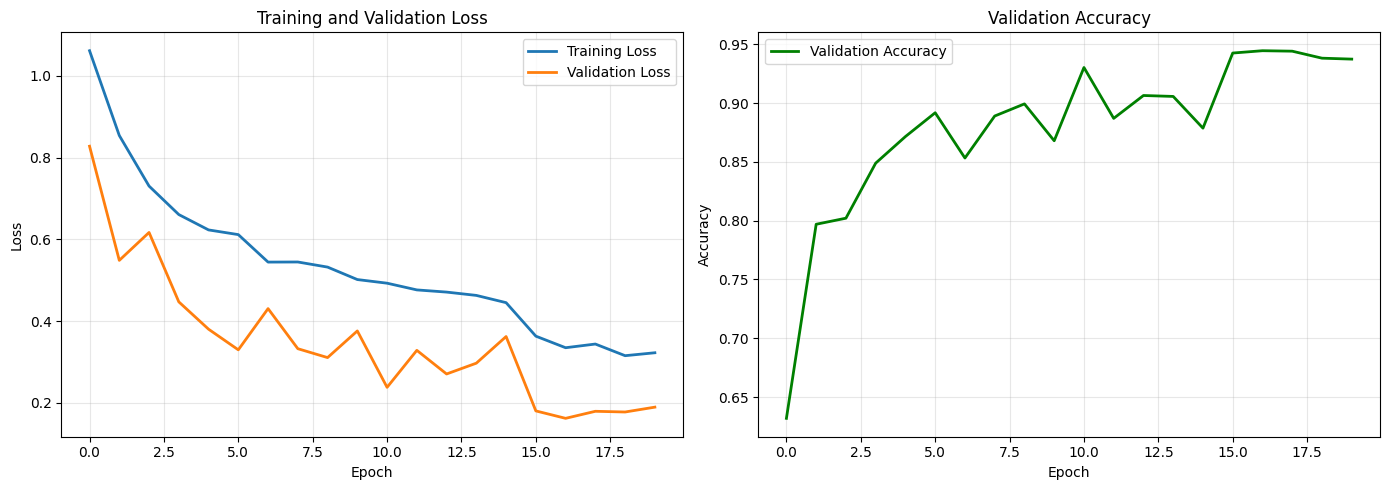

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], label='Training Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Model Loading

In [31]:
model.load_state_dict(torch.load('best_model.pth'))

model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing'):
        images = images.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.numpy())

test_accuracy = accuracy_score(all_labels, all_predictions)
print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Testing: 100%|████████████████████████████████████████████████████████████████████| 158/158 [01:14<00:00,  2.11it/s]


Test Accuracy: 0.9445 (94.45%)


Report

In [32]:
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      0.88      0.93       522
      Mosaic       0.87      0.98      0.92       462
      RedRot       0.94      0.97      0.95       518
        Rust       0.98      0.94      0.96       514
      Yellow       0.95      0.96      0.95       505

    accuracy                           0.94      2521
   macro avg       0.95      0.95      0.94      2521
weighted avg       0.95      0.94      0.94      2521



Confusion Matrix

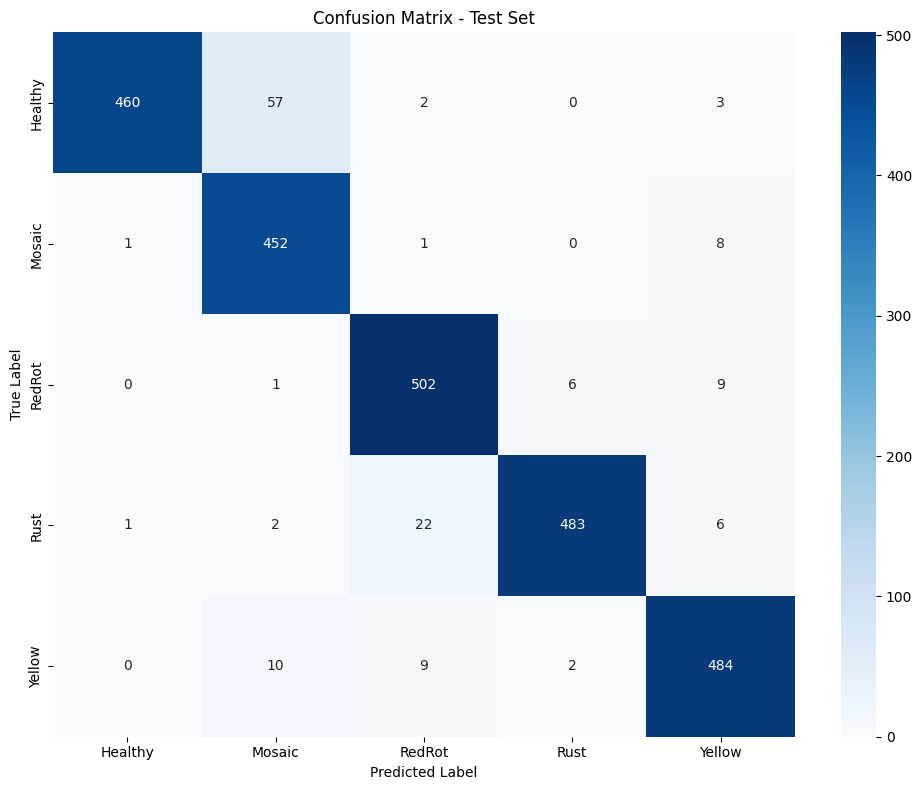

In [33]:
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

Visualization

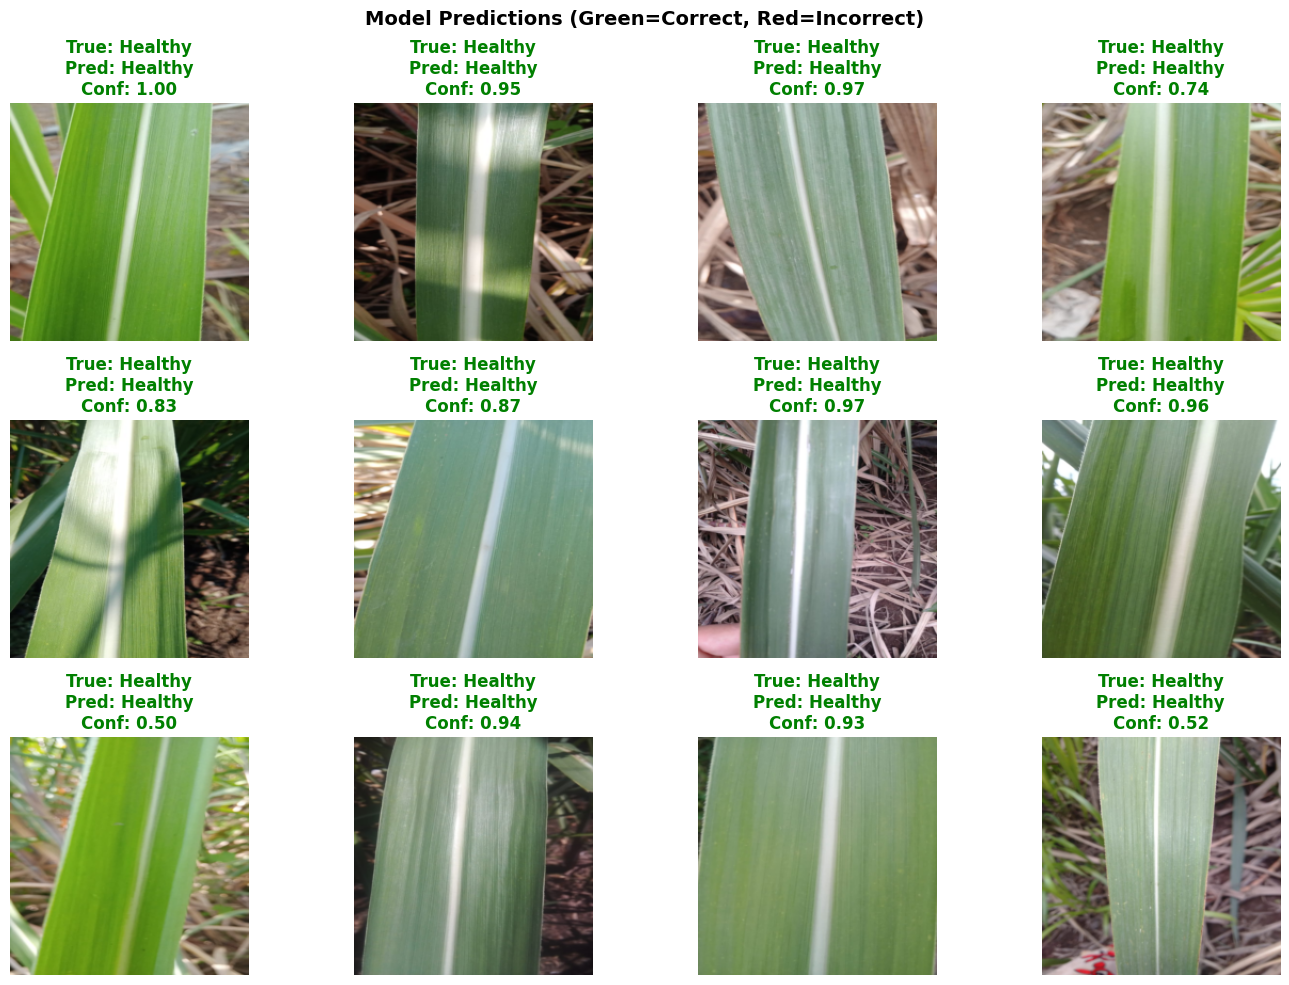

In [34]:
images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    probabilities = torch.softmax(outputs, dim=1)

fig, axes = plt.subplots(3, 4, figsize=(14, 10))
fig.suptitle('Model Predictions (Green=Correct, Red=Incorrect)', fontsize=14, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        img = denormalize(images[idx].cpu())
        ax.imshow(img)
        
        true_label = class_names[labels[idx].item()]
        pred_label = class_names[predictions[idx].item()]
        confidence = probabilities[idx].max().item()
        is_correct = predictions[idx] == labels[idx]
        
        color = 'green' if is_correct else 'red'
        title = f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}"
        ax.set_title(title, color=color, fontweight='bold')
        ax.axis('off')

plt.tight_layout()
plt.show()

Summary

In [35]:
summary = {
    'Total Images': len(full_dataset),
    'Training Images': len(train_dataset),
    'Validation Images': len(val_dataset),
    'Test Images': len(test_dataset),
    'Number of Classes': num_classes,
    'Best Validation Accuracy': f"{best_val_accuracy:.4f}",
    'Test Accuracy': f"{test_accuracy:.4f}",
    'Test Accuracy (%)': f"{test_accuracy*100:.2f}%"
}

print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)
for key, value in summary.items():
    print(f"{key}: {value}")
print("="*50)


FINAL RESULTS
Total Images: 2521
Training Images: 2521
Validation Images: 2521
Test Images: 2521
Number of Classes: 5
Best Validation Accuracy: 0.9445
Test Accuracy: 0.9445
Test Accuracy (%): 94.45%
